<ipython-input-5-dfc4b1d9d6be>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
<ipython-input-5-dfc4b1d9d6be>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
<ipython-input-5-dfc4b1d9d6be>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Model Accuracy (Optimal Threshold): 0.9675353863659939
Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1906351
           1       0.04      1.00      0.07      2435

    accuracy                           0.97   1908786
   macro avg       0.52      0.98      0.53   1908786
weighted avg       1.00      0.97      0.98   1908786



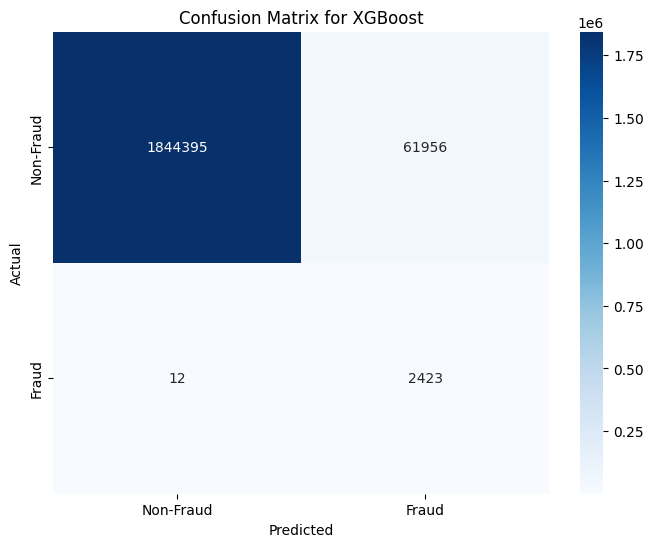


--- Data Drift Monitoring using PSI ---
PSI for amount: inf
Significant drift detected in feature 'amount' (PSI: inf)


<ipython-input-5-dfc4b1d9d6be>:75: RuntimeWarning: divide by zero encountered in log
  psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)


PSI for oldbalanceOrg: 0.000896312089842613
PSI for newbalanceOrig: 0.0016444256164145662
PSI for oldbalanceDest: 9.572023321632998e-07
PSI for newbalanceDest: 2.5395089827414046e-07
PSI for balance_diff: 9.923707149877757e-05
PSI for dest_balance_diff: 1.2493797305961025
Significant drift detected in feature 'dest_balance_diff' (PSI: 1.2493797305961025)
PSI for transaction_ratio: inf
Significant drift detected in feature 'transaction_ratio' (PSI: inf)


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and normalize data
synthetic_financial = pd.read_csv('Synthetic_Financial_datasets_log.csv')

# Define features and target
X = synthetic_financial[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = synthetic_financial['isFraud']

# Feature Engineering and Normalization
X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
X['transaction_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1e-9)  # Avoid division by zero

# Normalize features
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Define XGBoost parameters and train model
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'scale_pos_weight': len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    'eval_metric': 'auc',
    'random_state': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Initial training
bst_model = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, 'eval')], early_stopping_rounds=15, verbose_eval=False)

# Make predictions on the validation set
y_pred_proba = bst_model.predict(dval)

# Select optimal threshold (e.g., 0.3) based on previous analysis
optimal_threshold = 0.3
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

# Confusion Matrix and Classification Report at Optimal Threshold
accuracy_optimal = accuracy_score(y_val, y_pred_optimal)
classification_rep_optimal = classification_report(y_val, y_pred_optimal)
conf_matrix_optimal = confusion_matrix(y_val, y_pred_optimal)

print("Model Accuracy (Optimal Threshold):", accuracy_optimal)
print("Classification Report (Optimal Threshold):")
print(classification_rep_optimal)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for XGBoost')
plt.show()

# Data Drift Monitoring with PSI
def calculate_psi(expected, actual, bins=10):
    expected_percents, _ = np.histogram(expected, bins=bins, density=True)
    actual_percents, _ = np.histogram(actual, bins=bins, density=True)
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi = np.sum(psi_values)
    return psi

print("\n--- Data Drift Monitoring using PSI ---")
drift_threshold = 0.2
for feature in X.columns:
    psi_value = calculate_psi(X_train[feature], X_val[feature])
    print(f"PSI for {feature}: {psi_value}")
    if psi_value > drift_threshold:
        print(f"Significant drift detected in feature '{feature}' (PSI: {psi_value})")

<ipython-input-7-32d134dd7074>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
<ipython-input-7-32d134dd7074>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
<ipython-input-7-32d134dd7074>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 


--- Data Drift Monitoring using PSI ---
PSI for amount: inf
Significant drift detected in feature 'amount' (PSI: inf)


<ipython-input-7-32d134dd7074>:31: RuntimeWarning: divide by zero encountered in log
  psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)


PSI for oldbalanceOrg: 0.000896312089842613
PSI for newbalanceOrig: 0.0016444256164145662
PSI for oldbalanceDest: 9.572023321632998e-07
PSI for newbalanceDest: 2.5395089827414046e-07
PSI for balance_diff: 9.923707149877757e-05
PSI for dest_balance_diff: 1.2493797305961025
Significant drift detected in feature 'dest_balance_diff' (PSI: 1.2493797305961025)
PSI for transaction_ratio: inf
Significant drift detected in feature 'transaction_ratio' (PSI: inf)


<ipython-input-7-32d134dd7074>:48: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train['transaction_ratio'], label='Training Data', shade=True, color='blue')
<ipython-input-7-32d134dd7074>:51: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_val['transaction_ratio'], label='Validation Data', shade=True, color='red')


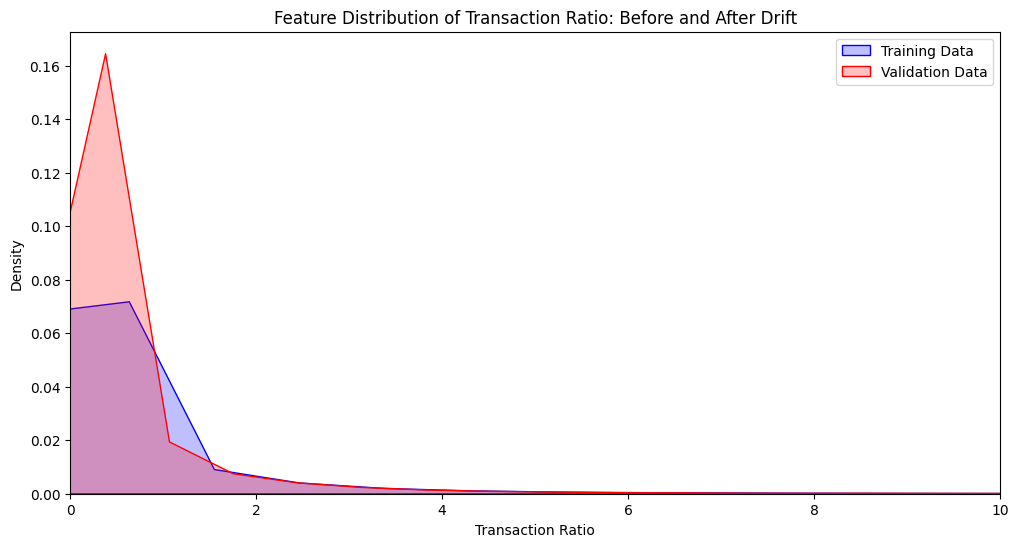

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Synthetic Fraud Dataset
synthetic_financial = pd.read_csv('Synthetic_Financial_datasets_log.csv')

# Define features and target
X = synthetic_financial[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = synthetic_financial['isFraud']

# Feature Engineering
X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
X['transaction_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1e-9)  # Avoid division by zero

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Data Drift Monitoring with PSI
def calculate_psi(expected, actual, bins=10):
    expected_percents, _ = np.histogram(expected, bins=bins, density=True)
    actual_percents, _ = np.histogram(actual, bins=bins, density=True)
    psi_values = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi = np.sum(psi_values)
    return psi

# Calculate PSI for each feature
print("\n--- Data Drift Monitoring using PSI ---")
drift_threshold = 0.2
for feature in X.columns:
    psi_value = calculate_psi(X_train[feature], X_val[feature])
    print(f"PSI for {feature}: {psi_value}")
    if psi_value > drift_threshold:
        print(f"Significant drift detected in feature '{feature}' (PSI: {psi_value})")

# Plot feature distribution for 'transaction_ratio' before and after drift
plt.figure(figsize=(12, 6))

# Plot before drift (Training Data)
sns.kdeplot(X_train['transaction_ratio'], label='Training Data', shade=True, color='blue')

# Plot after drift (Validation Data)
sns.kdeplot(X_val['transaction_ratio'], label='Validation Data', shade=True, color='red')

plt.title('Feature Distribution of Transaction Ratio: Before and After Drift')
plt.xlabel('Transaction Ratio')
plt.ylabel('Density')
plt.xlim(0, 10)  # Adjust x-axis range to focus on the main distribution
plt.legend()
plt.show()

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the Dataset
# Replace with the correct path if needed
synthetic_financial = pd.read_csv('Synthetic_Financial_datasets_log.csv')

# Quick overview of the dataset
print("Dataset Overview:")
print(synthetic_financial.head())
print(synthetic_financial.info())

# Step 3: Define Features and Target
X = synthetic_financial[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
y = synthetic_financial['isFraud']

# Step 4: Feature Engineering
X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
X['transaction_ratio'] = X['amount'] / (X['oldbalanceOrg'] + 1e-9)  # Avoid division by zero

# Step 5: Normalize Features
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 6: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Step 7: Train and Evaluate SVM (RBF Kernel)
svm_rbf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_rbf.fit(X_train, y_train)

# Predictions
y_pred_svm_rbf = svm_rbf.predict(X_val)
y_pred_prob_svm_rbf = svm_rbf.predict_proba(X_val)[:, 1]

# Evaluation Metrics for SVM (RBF Kernel)
print("\nSVM (RBF Kernel) Results:")
print("Classification Report:")
print(classification_report(y_val, y_pred_svm_rbf))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_svm_rbf))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob_svm_rbf):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_svm_rbf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (RBF Kernel)')
plt.show()

# Step 8: Train and Evaluate SVM (Linear Kernel)
svm_linear = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm_linear.fit(X_train, y_train)

# Predictions
y_pred_svm_linear = svm_linear.predict(X_val)
y_pred_prob_svm_linear = svm_linear.predict_proba(X_val)[:, 1]

# Evaluation Metrics for SVM (Linear Kernel)
print("\nSVM (Linear Kernel) Results:")
print("Classification Report:")
print(classification_report(y_val, y_pred_svm_linear))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_svm_linear))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob_svm_linear):.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_svm_linear), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (Linear Kernel)')
plt.show()


Dataset Overview:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data co

<ipython-input-1-e73cbb5b8849>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['balance_diff'] = X['newbalanceOrig'] - X['oldbalanceOrg']
<ipython-input-1-e73cbb5b8849>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['dest_balance_diff'] = X['newbalanceDest'] - X['oldbalanceDest']
<ipython-input-1-e73cbb5b8849>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 